In [1]:
%load_ext autoreload

In [2]:
dataname="synthetic"
gpuid=0

patch_size=224 #should match the value used to train the network

In [19]:
import torch
print(torch.__version__)
import torchvision
print(torchvision.__version__)

1.5.0+cu101
0.6.0+cu101


In [3]:
import matplotlib.pyplot as plt
import numpy as np

import tables
import math

import torch
from torchvision.models import DenseNet
from torch.autograd import Variable
from torchvision import transforms

In [4]:
print(torch.cuda.get_device_properties(gpuid))
torch.cuda.set_device(gpuid)
device = torch.device(f'cuda:{gpuid}' if torch.cuda.is_available() else 'cpu')

_CudaDeviceProperties(name='Tesla K80', major=3, minor=7, total_memory=11441MB, multi_processor_count=13)


In [5]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [6]:
%cd My\ Drive/PytorchDigitalPathology/visualization_densenet

/gdrive/My Drive/PytorchDigitalPathology/visualization_densenet


In [7]:
checkpoint = torch.load(f"{dataname}_densenet_best_model.pth",  map_location=lambda storage, loc: storage) #load checkpoint to CPU and then put to dev

In [8]:
#load the model, note that the paramters are coming from the checkpoint, since the architecture of the model needs to exactly match the weights saved

model = DenseNet(growth_rate=checkpoint["growth_rate"], block_config=checkpoint["block_config"],
                 num_init_features=checkpoint["num_init_features"], bn_size=checkpoint["bn_size"], drop_rate=checkpoint["drop_rate"], num_classes=checkpoint["n_classes"]).to(device)

print(f"total params: \t{sum([np.prod(p.size()) for p in model.parameters()])}")
model.load_state_dict(checkpoint["model_dict"])

total params: 	58212


<All keys matched successfully>

In [9]:
phase="val"
db=tables.open_file(f"./{dataname}_{phase}.pytable")

In [10]:
img_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomCrop(size=(patch_size,patch_size),pad_if_needed=True), #these need to be in a reproducible order, first affine transforms and then color
    transforms.ToTensor()
    ])

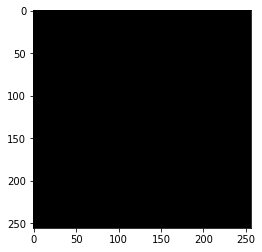

In [11]:
imgid=19

img = db.root.imgs[imgid,::]
#label = torch.tensor(db.root.labels[imgid])
label = torch.tensor(np.array(db.root.labels[imgid]))

img = img[:,:,None].repeat(3,axis=2) #convert to 3 channel

timg=img_transform(img)

plt.imshow(img)

In [12]:
model.eval()

timg = timg.to(device)  # [1, 3, H, W]
label = label.type('torch.LongTensor').to(device)  # [1] with class indices (0, 1)

output = model(timg[None,::])  
output=output.detach().squeeze().cpu().numpy() #get output and pull it to CPU
    
predlabel=np.argmax(output)
print(f"class vals: {output}")
print(f"actual class: {label}")
print(f"predicted class: {predlabel}")

class vals: [ 1.5640597 -2.2305996]
actual class: 0
predicted class: 0


In [13]:
!cp -r 'pytorch-cnn-visualizations/' /content

In [14]:
import sys
sys.path.append('/content/pytorch-cnn-visualizations/src/')

In [15]:
from misc_functions import convert_to_grayscale

In [16]:
def rescale_grads(map,gradtype="all"):
    if(gradtype=="pos"):    #positive
        map = (np.maximum(0, map) / map.max())
    elif gradtype=="neg":
        map = (np.maximum(0, -map) / -map.min())
    else:
        map = map - map.min()
        map /= map.max()
    return map

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


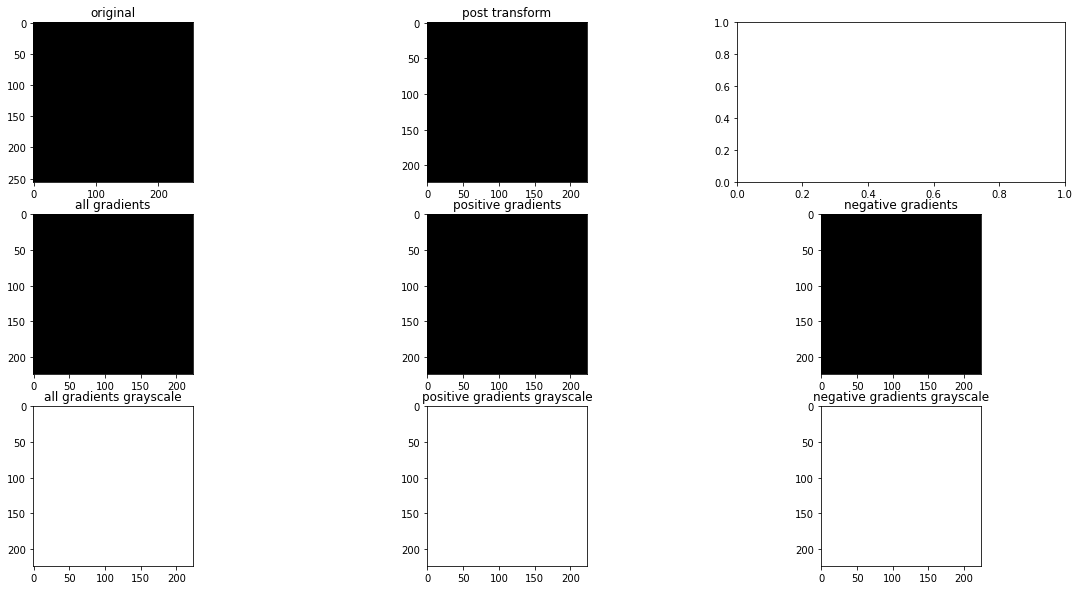

In [24]:
from vanilla_backprop import VanillaBackprop
VBP = VanillaBackprop(model,device)
vanilla_grads = VBP.generate_gradients(timg[None,::], label)
vanilla_grads=np.moveaxis(vanilla_grads,0,-1)

fig, ax = plt.subplots(3,3, figsize=(20,10))
ax = ax.flatten()

ax[0].set_title("original")
ax[0].imshow(img)

ax[1].set_title("post transform")
ax[1].imshow(np.moveaxis(timg.cpu().numpy().squeeze(),0,-1))

ax[3].set_title("all gradients")
ax[3].imshow(rescale_grads(vanilla_grads,gradtype="all"))

ax[4].set_title("positive gradients")
ax[4].imshow(rescale_grads(vanilla_grads,gradtype="pos"))

ax[5].set_title("negative gradients")
ax[5].imshow(rescale_grads(vanilla_grads,gradtype="neg"))

ax[6].set_title("all gradients grayscale")
ax[6].imshow(convert_to_grayscale(rescale_grads(vanilla_grads,gradtype="all")))

ax[7].set_title("positive gradients grayscale")
ax[7].imshow(convert_to_grayscale(rescale_grads(vanilla_grads,gradtype="pos")))

ax[8].set_title("negative gradients grayscale")
ax[8].imshow(convert_to_grayscale(rescale_grads(vanilla_grads,gradtype="neg")))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


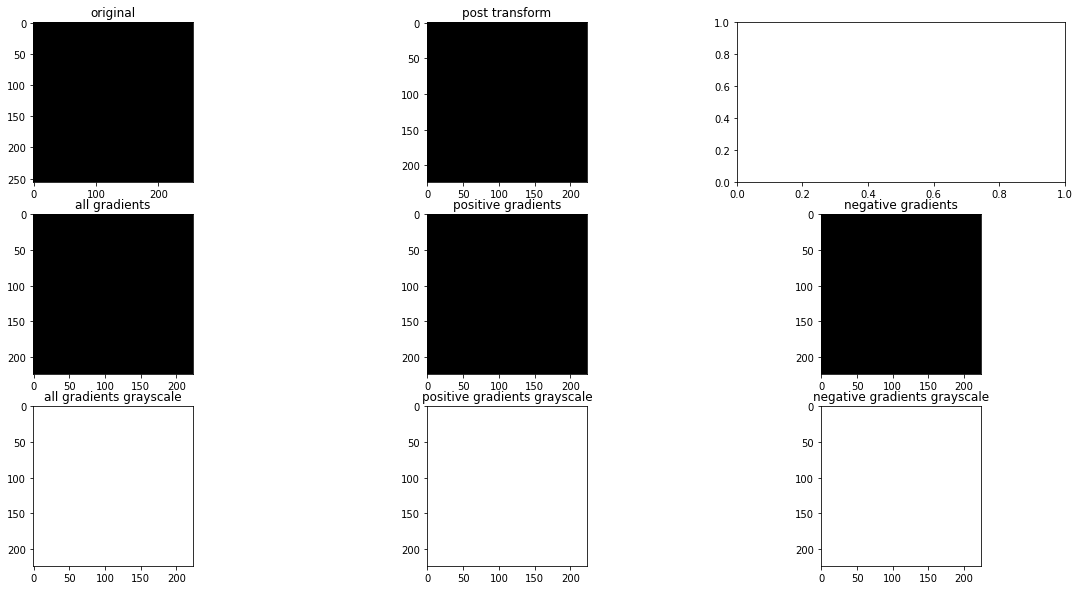

In [21]:
from guided_backprop import GuidedBackprop
GB=GuidedBackprop(model,device)
gp_grads=GB.generate_gradients(timg[None,::], label)


gp_grads=np.moveaxis(gp_grads,0,-1)

fig, ax = plt.subplots(3,3, figsize=(20,10))
ax = ax.flatten()

ax[0].set_title("original")
ax[0].imshow(img)

ax[1].set_title("post transform")
ax[1].imshow(np.moveaxis(timg.cpu().numpy().squeeze(),0,-1))

ax[3].set_title("all gradients")
ax[3].imshow(rescale_grads(gp_grads,gradtype="all"))

ax[4].set_title("positive gradients")
ax[4].imshow(rescale_grads(gp_grads,gradtype="pos"))

ax[5].set_title("negative gradients")
ax[5].imshow(rescale_grads(gp_grads,gradtype="neg"))

ax[6].set_title("all gradients grayscale")
ax[6].imshow(convert_to_grayscale(rescale_grads(gp_grads,gradtype="all")))

ax[7].set_title("positive gradients grayscale")
ax[7].imshow(convert_to_grayscale(rescale_grads(gp_grads,gradtype="pos")))

ax[8].set_title("negative gradients grayscale")
ax[8].imshow(convert_to_grayscale(rescale_grads(gp_grads,gradtype="neg")))

/content/pytorch-cnn-visualizations/src/gradcam.py:93: RuntimeWarning: invalid value encountered in true_divide
  cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))  # Normalize between 0-1


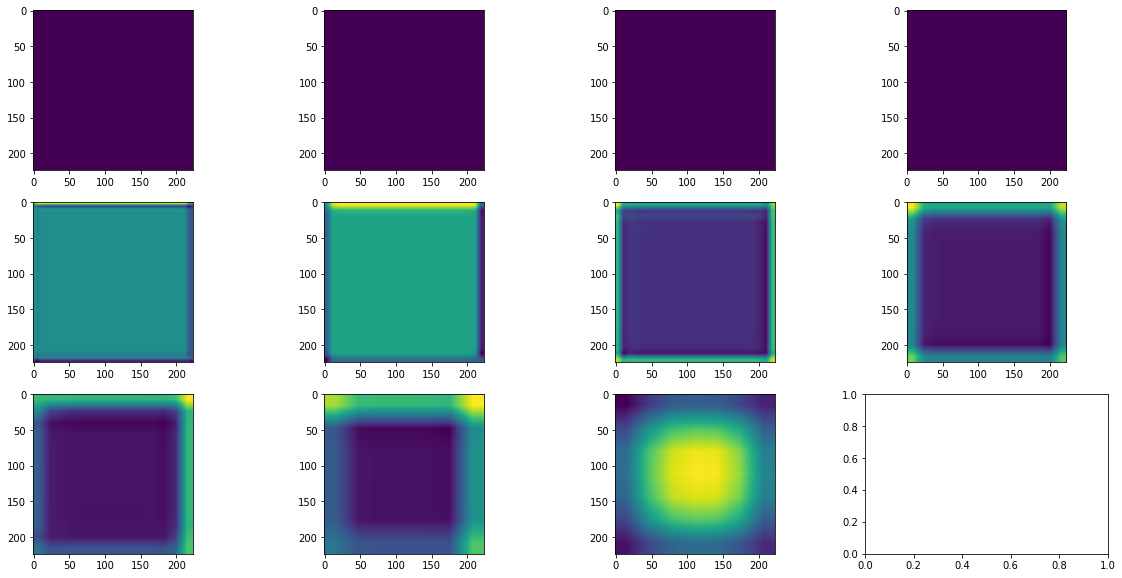

In [22]:
from gradcam import GradCam

nlayers=len(model.features._modules.items())-1

fig, ax = plt.subplots(math.ceil(nlayers/4),4, figsize=(20,10))
ax = ax.flatten()

for layer in range(nlayers):
    grad_cam = GradCam(model, device,target_layer=layer)
    cam = grad_cam.generate_cam(timg[None,::], label)
    ax[layer].imshow(cam)

/content/pytorch-cnn-visualizations/src/gradcam.py:93: RuntimeWarning: invalid value encountered in true_divide
  cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))  # Normalize between 0-1
/content/pytorch-cnn-visualizations/src/misc_functions.py:29: RuntimeWarning: invalid value encountered in true_divide
  grayscale_im = (np.clip((grayscale_im - im_min) / (im_max - im_min), 0, 1))
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.6/dist-packages/numpy/core/_

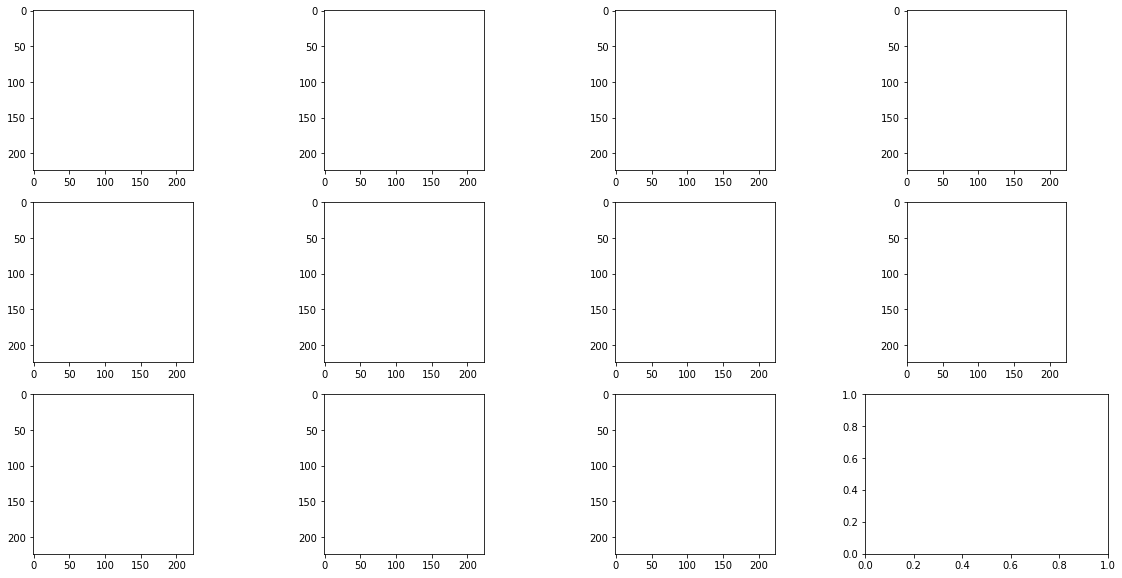

In [23]:
from gradcam import GradCam
from guided_gradcam import guided_grad_cam
from guided_backprop import GuidedBackprop

nlayers=len(model.features._modules.items())-1

fig, ax = plt.subplots(math.ceil(nlayers/4),4, figsize=(20,10))
ax = ax.flatten()

for layer in range(nlayers):
    #GradCam
    grad_cam = GradCam(model, device,target_layer=layer)
    cam = grad_cam.generate_cam(timg[None,::], label)
    
    #GuidedBackprop
    GBP = GuidedBackprop(model, device)
    guided_grads = GBP.generate_gradients(timg[None,::], label)
    
    # Guided Grad cam
    cam_gb = guided_grad_cam(cam, guided_grads)
    
    ax[layer].imshow(convert_to_grayscale(np.moveaxis(cam_gb,0,-1)))